In [1]:
%run 00_analysis_config.ipynb

Welcome to JupyROOT 6.24/06

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [2]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis
reload(vis)

<module 'visualization' from '/project/6035200/tomren/jupyter/tracker_6layers/visualization.py'>

In [3]:
# sys.path.append("'/project/6035200/tomren/jupyter/tracker_6layers/scripts")
%run ./scripts/sim_filereader_helper.py

### Generate simulation script

Two simulation scripts are generated:

1. Each event consists of two muons with arbiturary angle within a cone 
2. Each event is calculated from a two-body decay with momentum direction pointing from CMS to the vertex

In [4]:
def generate_twobody_vertex_range(filename, abs_momentum, vertex_xyz, theta_range, p_unit_pre=[1,1,-1], phi_range=[0,2*np.pi], decayproduct_pid=[13,13], rand_seed=None, Nevents=10000, OVER_WRITE=False):
    """
    INPUT
    ---
    filename:
        str, the filename of the event description file to be generated
    abs_momentum: 
        float, absolute momentum of the two particles [MeV]
    vertex_xyz: [x,y,z] or [[x0,x1], [y0,y1], [z0,z1]], in unit of [cm]
        [x,y,z] in **DETECTOR** coordinates! It's the same coordinates as the x,y,z of the 'Range' generator in simulation output.
        [[x0,x1], [y0,y1], [z0,z1]]: ranges of xyz, will generate uniform distributed xyz. 
    decayproduct_pid:
        [pid1, pid2], PID of the two decay products. Used to decide the mass of the decay particle.
    rand_seed: 
        If None, then fresh, unpredictable entropy will be pulled from the OS. 
    which_coordinate:
        "CMS" or "detector"
    """    
    
    if os.path.exists(filename):
        print("File exists!")
        if not OVER_WRITE:
            print("Please change filename, or set OVER_WRITE=True")
            return
        
    # Transform vertex position to detector coordinate to feed to simulation
    vertex_xyz = np.array(vertex_xyz)
    vertex_xyz_det = vertex_xyz*10
        
    rng = np.random.default_rng(seed=rand_seed)
    with open(filename, "w") as file:
        # first, write the total number of events
        file.write(f"# nevents {Nevents}\n\n")
        for i in range(Nevents):
            file.write(f"n {i}\n")
            rand_seed_i = None if rand_seed is None else rand_seed+i
            
            pvecs=[]
            for ivec in range(2):
                theta = rng.uniform(*theta_range)
                phi = rng.uniform(*phi_range)
                p_unit=np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), -np.cos(theta)])
                p_unit=p_unit/np.sqrt(np.sum(p_unit**2))*p_unit_pre
                p = abs_momentum*p_unit         
                pvecs.append(p)
            
            # Generate a random vertex if a range was given
            if vertex_xyz.ndim==2:
                vertex_temp = np.array([rng.uniform(*vertex_xyz[0]), rng.uniform(*vertex_xyz[1]), rng.uniform(*vertex_xyz[2])])
                vertex_xyz_det = vertex_temp*10
                    

            file.write(f"\t {decayproduct_pid[0]}\t  {vertex_xyz_det[0]}\t  {vertex_xyz_det[1]}\t {vertex_xyz_det[2]}\t {pvecs[0][0]}\t {pvecs[0][1]}\t {-pvecs[0][2]}\n")
            file.write(f"\t {decayproduct_pid[0]}\t  {vertex_xyz_det[0]}\t  {vertex_xyz_det[1]}\t {vertex_xyz_det[2]}\t {pvecs[1][0]}\t {pvecs[1][1]}\t {-pvecs[1][2]}\n")

In [5]:
#-------------------
# Script 1
OVER_WRITE=False
data_filename = "scripts/filereader_mumu_range_CenterModule.txt"
abs_momentum=10000
vertex_xyz = np.array([124.5, 5, 10])*100 # [cm]
theta_range = [-np.arctan(4/21),np.arctan(4/21)]
nevents = 10000
generate_twobody_vertex_range(data_filename, abs_momentum, vertex_xyz, theta_range,\
                              phi_range=[0,2*np.pi], decayproduct_pid=[13,13], rand_seed=1, Nevents=nevents, OVER_WRITE=OVER_WRITE)
        
        
with open(os.path.splitext(data_filename)[0]+".mac","w+")  as f:
    f.write(f"/det/select Box \n")
    f.write(f"/gen/select file_reader \n")
    f.write(f"/gen/file_reader/pathname {os.path.abspath(data_filename)} \n")
    f.write(f"/run/beamOn {nevents} \n")

File exists!
Please change filename, or set OVER_WRITE=True


In [6]:
#-------------------
# Script 2
OVER_WRITE = True
M=4000
P=40000
nevents = 10_000 # number of events
filename=f"scripts/filereader_muon_M{M}_P{P}_N{nevents}.txt"

# box_lim: [cm] 2-d means the range of vertex location
# box_lim = np.array([[70.0, 70+99], [-49.5, 49.5], [-6, 25-6]])*100 # [cm] xyz limit of the decay volume, detector coordinate

# box_lim: [cm] 1-d means the preciselocation of the vertex
box_lim = np.array([124.5-40, 5, 10])*100  # [cm], Set the vertex to 10m below the edge module

generate_twobody_decay_file(filename, M, P, box_lim, decayproduct_pid=[13,13], Nevents=nevents, rand_seed=1, OVER_WRITE=OVER_WRITE,which_coordinate="detector")
generate_sim_script_filereader(os.path.abspath(filename))


# Run with:
# simulation -q -o /project/def-mdiamond/tomren/mathusla/data/fit_study_6layer/XtoMuMu_M4GeV_P40GeV/ -s filereader_muon_M4000_P40000_N10000.mac

File exists!
Script saved at /project/6035200/tomren/jupyter/tracker_6layers/scripts/filereader_muon_M4000_P40000_N10000.mac


'/project/6035200/tomren/jupyter/tracker_6layers/scripts/filereader_muon_M4000_P40000_N10000.mac'

### Inspect the simulation

In [31]:
filename = f"{DATA_DIR}/XtoMuMu_M4GeV_P40GeV/20230523/131132/run0.root"
# filename = f"{DATA_DIR}/XtoMuMu_P10GeV_manual/20230523/131132//run0.root"
tfile = root.TFile.Open(filename)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)

nevents = int(Tree.GetEntries())
branch_list = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
print("Number of events",nevents)

Number of events 10000


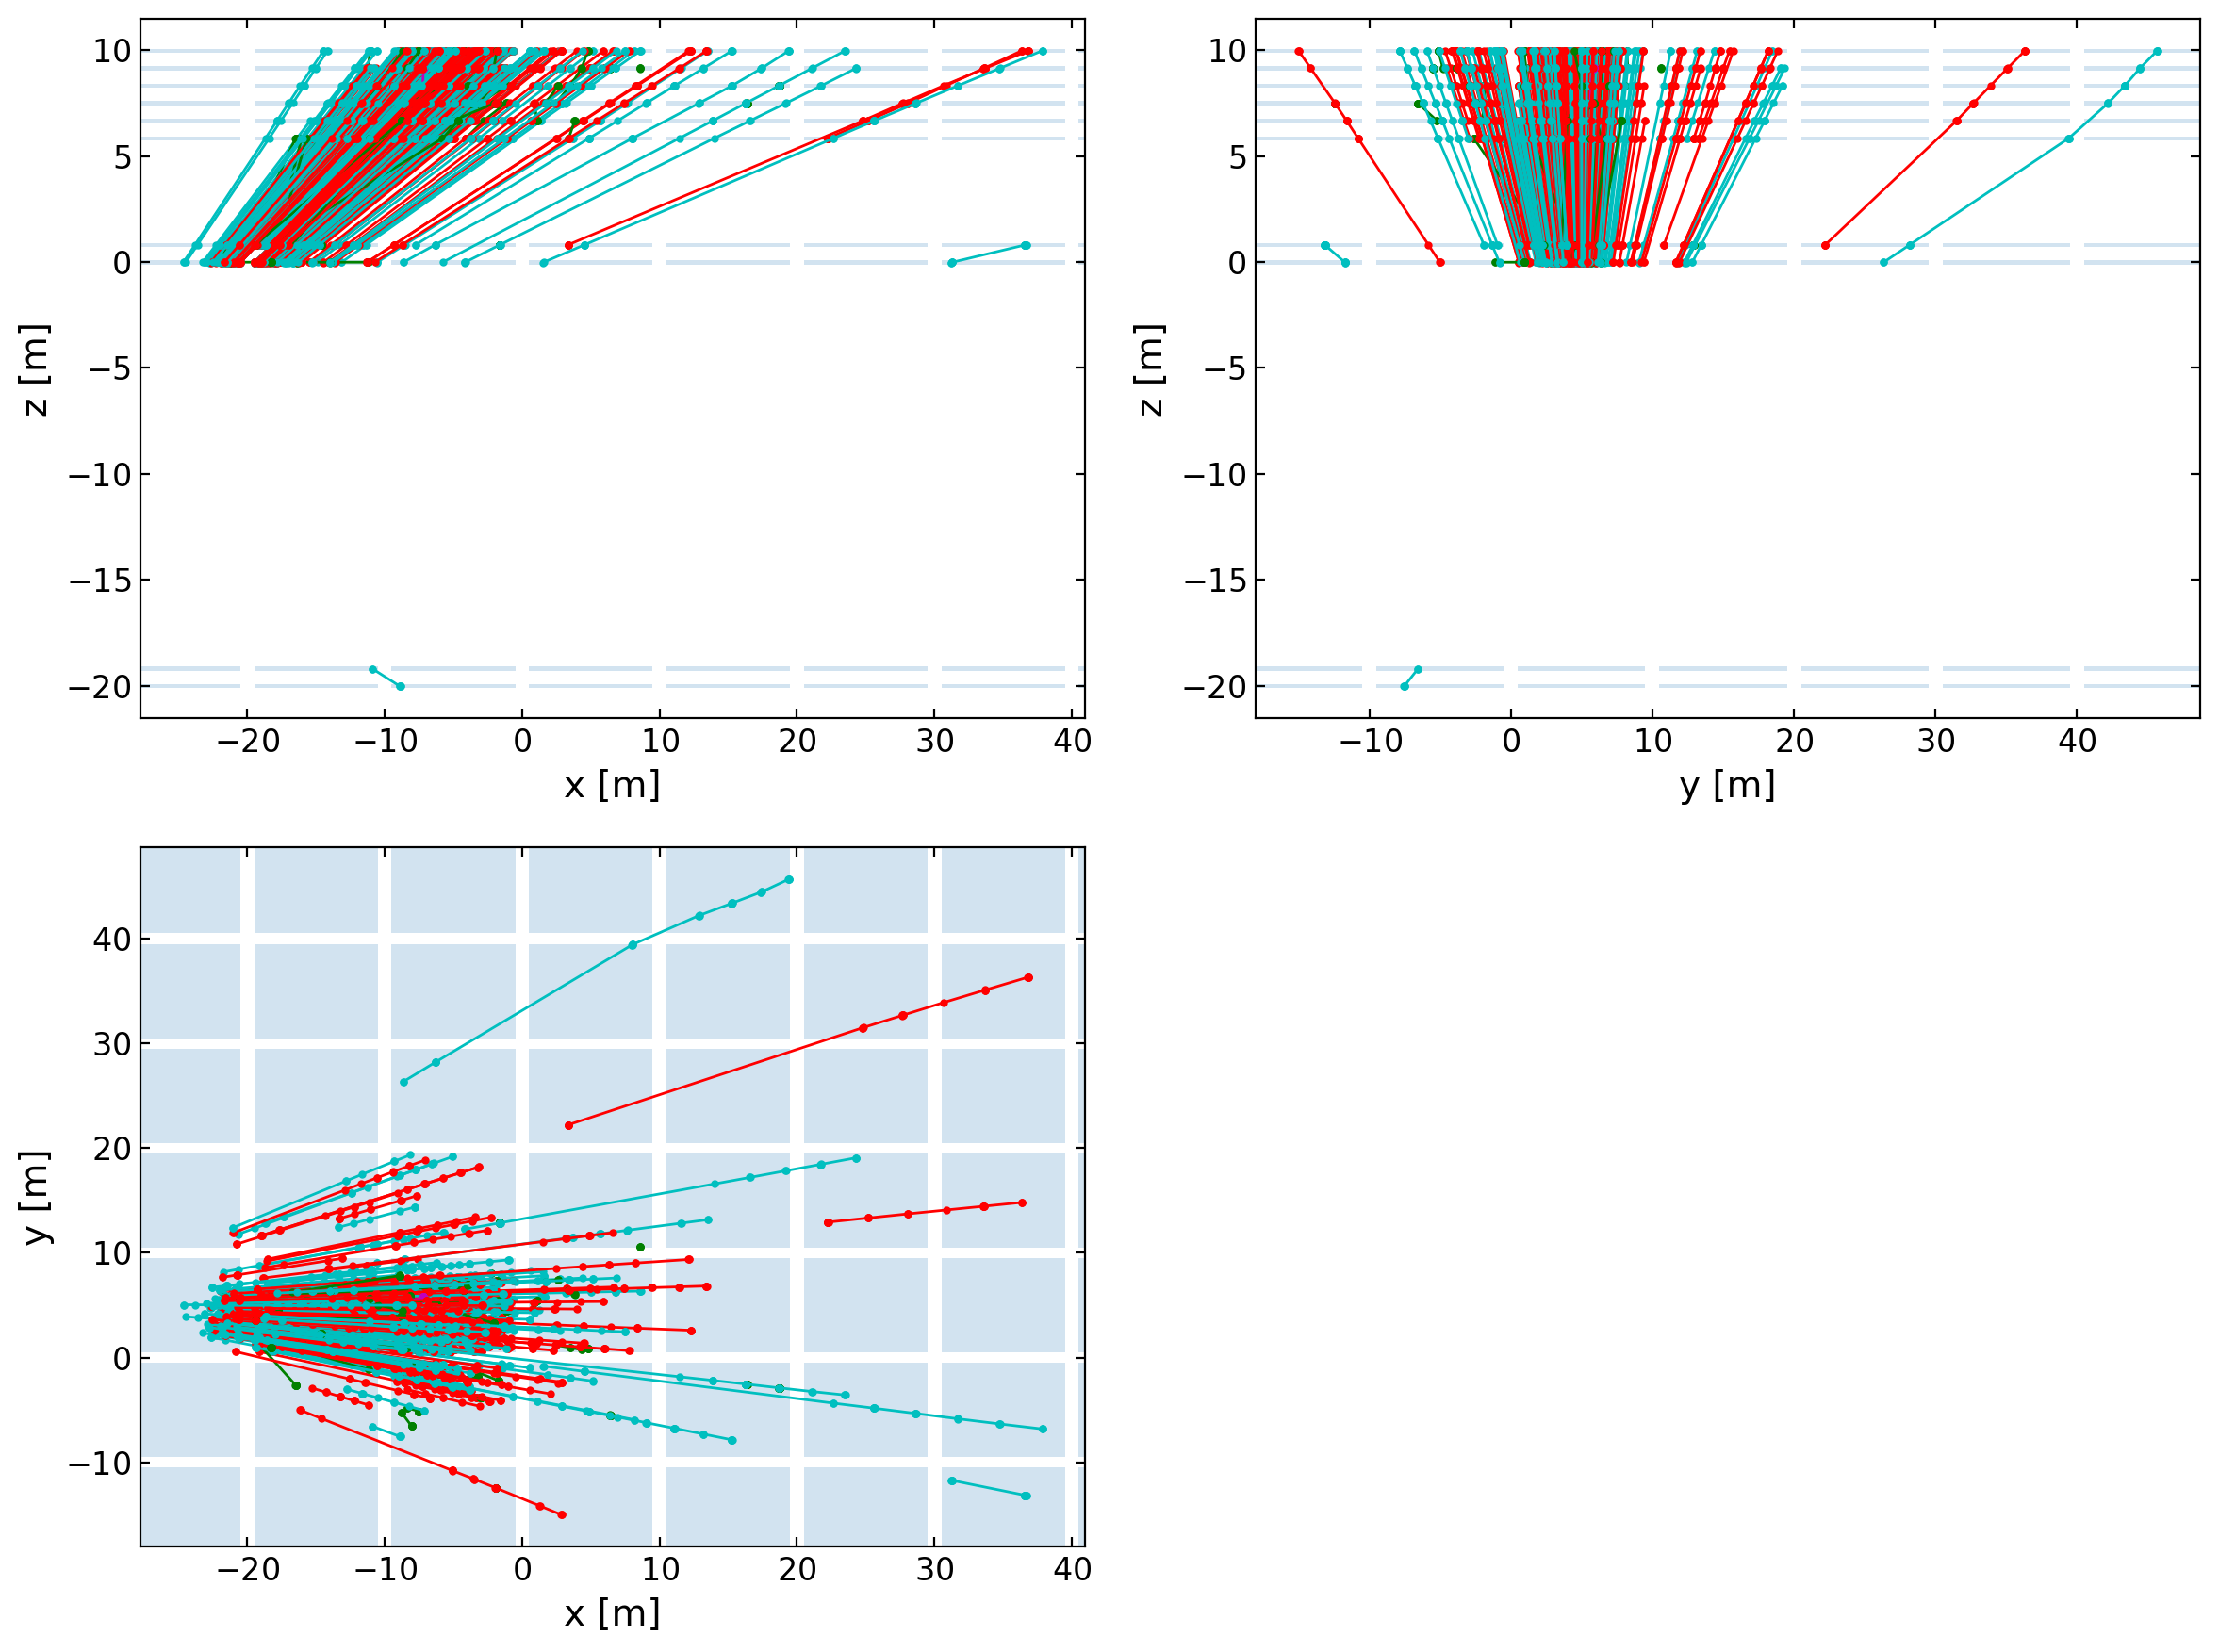

In [32]:
ev = event.Event(filename, 0, tree_name=tree_name)

fig,axs=plt.subplots(2,2,figsize=(12,9))
for i in range(100):
    ev.EventNumber=i
    # Plot truth
    fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False,make_legend=False);
fig = vis.plot_truth(ev,fig=fig, disp_det_view=True, disp_vertex=False, disp_first_hit=False,make_legend=False);

# Reconstruction efficiency

In [10]:
filename_recon = os.path.dirname(filename)+"/stat_seedmod.root"
tfile = root.TFile.Open(filename_recon)
tree_name = tfile.GetListOfKeys()[0].GetName()
Tree = tfile.Get(tree_name)
ev = event.Event(filename_recon, 0, tree_name=tree_name)

nevents = int(Tree.GetEntries())
branch_list = [Tree.GetListOfBranches()[i].GetName() for i in range(len(Tree.GetListOfBranches()))]
print("Number of events",nevents)
print(branch_list)

Number of events 10000
['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Digi_numHits', 'Digi_time', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_energy', 'Digi_px', 'Digi_py', 'Digi_pz', 'Digi_particle_energy', 'Digi_pdg_id', 'Digi_seed', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mass', 'G4KLong_code', 'EXTRA_12', 'EXTRA_13', 'EXTRA_14', 'EXTRA_15', 'Vertex_k_m_t', 'Vertex_k_m_x', 'Vertex_k_m_y', 'Vertex_k_m_z', 'Vertex_k_m_ErrorT', 'Vertex_k_m_ErrorX', 'Vertex_k_m_ErrorY', 'Vertex_k_m_ErrorZ', 'vertex_k_m_chi2', 'Vertex_k_m_trackIndices', 'NumVertices_k_m', 'Track_k_m_velX', 'Track_k_m_velY', 'Track_k_m_velZ', 'Track_k_m_x0', 'Track_k_m_y0', 'Track_k

In [11]:
ev.Tree.GetEntry(2)
%timeit -n 10 ev.ExtractTruthPhysics_list();

827 µs ± 129 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
def get_km_alltracks(filename, results_fit = None, tree_name="integral_tree", truth_pids = [13,13], nevents=-1):
    """
    Parameters
    ---
    nevents: 
      -1: all events
      (start, stop) from start to stop
    """
    
    if results_fit is None:
        results_fit={}

        
    results_fit["Entry"]=[]               # ROOT event entry number
    results_fit["ndigi"]=[]               # Total number of digitized hits
    results_fit["mask_recon_success_track"]=[]    # Boolean mask 
    results_fit["mask_recon_success_vertex"]=[]   # Boolean mask 
    
    results_fit["tracks_truth"]=[]
    results_fit["tracks_truth_n"]=[]
    results_fit["tracks_truth_nlayer"]=[]
    
    results_fit["tracks_recon"]=[]
    results_fit["tracks_recon_n"]=[]
    results_fit["tracks_recon_error"]=[]          # KF parameter uncertainty. Already taken sqrt()
    results_fit["tracks_ndigi"]=[]          #  number of digitized hits in the track
    results_fit["tracks_ndigi_false"]=[]    #  number of digitized hits in the track that are not from the truth
    results_fit["tracks_purity"]=[]         # List of PDG id of hits in this track 
    results_fit["tracks_pdgids"]=[]         # List of PDG id of hits in this track 
    results_fit["tracks_chi2"]=[]           # KF fit chi2
    
    results_fit["vertices_recon"]=[]
    results_fit["vertices_recon_n"]=[]
    results_fit["vertices_recon_error"]=[]
    results_fit["vertices_chi2"]=[]
    


    ev = event.Event(filename, 0, tree_name=tree_name)
    Tree=ev.Tree
    nevents_total = int(ev.Tree.GetEntries())
    cut=cutflow.sample_space("")
    
    if nevents==-1:
        nevents = [0, nevents_total]
    elif type(nevents) is int:
        if nevents_total<nevents:
            print(f"Requested events exceed total {nevents_total}")
        nevents = [0, min(nevents,nevents_total)]
    else:
        if nevents_total<nevents[1]:
            print(f"Requested events exceed total {nevents_total}")        
        nevents = [nevents[0], min(nevents[1],nevents_total)]

    for i_event in tqdm(range(nevents[0], nevents[1])):
        ev.EventNumber=i_event
        ev.Tree.GetEntry(i_event)
        ev.ExtractTruthPhysics_list()
        
        par_km_ndigi = ev.Tree.Digi_x.size()
        
        results_fit["Entry"].append(i_event)
        results_fit["ndigi"].append(par_km_ndigi)
        
        # Get truth (speed need to be calculated by hand)
        try:
            # Truth position and speed
            TruthTracks = []
            Truths = []
            Truth_nlayer = []
            for track in ev.truthTrackList_list:
                if track[4][0] in truth_pids:
                    TruthTracks.append(track)
                    dt=track[3][1]-track[3][0]
                    vx=(track[0][1]-track[0][0])/dt
                    vy=(track[1][1]-track[1][0])/dt
                    vz=(track[2][1]-track[2][0])/dt
                    truth = [track[0][0], track[1][0], track[2][0], track[3][0],vx,vy,vz]  
                    Truths.append(truth)
                    Truth_nlayer.append(np.abs(cut.in_layer(track[1][-1])-cut.in_layer(track[1][0])))
            
            n_truthtracks=len(TruthTracks)
            results_fit["tracks_truth"].append(Truths)  
            results_fit["tracks_truth_n"].append(n_truthtracks)  
            results_fit["tracks_truth_nlayer"].append(Truth_nlayer)  
            
        except:
            n_truthtracks=0
            results_fit["tracks_truth"].append([[-9999]])
            results_fit["tracks_truth_n"].append(n_truthtracks)  
            results_fit["tracks_truth_nlayer"].append([[-9999]])
                  
        
        # If there is reconstruction:
        if len(ev.Tree.Track_k_m_z0)==0:
            tracks_recon = [[-9990, -9990, -9990, -9990, -9990, -9990, -9990]]
            tracks_recon_n = 0
            tracks_recon_error = [[-9990, -9990, -9990, -9990, -9990, -9990, -9990]]
            tracks_chi2 = [0]
            
            tracks_ndigi = [0]
            tracks_ndigi_false = [0]
            tracks_purity = [0]
            tracks_pdgids = [0]
            results_fit["mask_recon_success_track"].append(False)
            
        else:
            tracks_recon = []
            tracks_recon_n = Tree.Track_k_m_z0.size()
            tracks_recon_error = []
            tracks_chi2 = []
            tracks_ndigi = []
            tracks_ndigi_false = []
            tracks_purity = []
            tracks_pdgids = []            
            
            
            # Select the reconstruction that is closest to truth
            track_digi_hit_inds = util.unzip(Tree.Track_k_m_hitIndices)
            track_truth_ids = util.unzip(Tree.Track_k_m_ids)
            track_digi_hit_len = np.array([len(i) for i in track_digi_hit_inds])
            if tracks_recon_n<n_truthtracks:
                results_fit["mask_recon_success_track"].append(False)
            else:
                results_fit["mask_recon_success_track"].append(True)                
                
            for i_track in range(len(TruthTracks)):
                truth = Truths[i_track]

                track_chi2s = []
                if len(track_digi_hit_inds)>1:
                    for track_ind in range(len(track_digi_hit_inds)):
                        recon_i = [Tree.Track_k_m_x0.at(track_ind), Tree.Track_k_m_y0.at(track_ind), Tree.Track_k_m_z0.at(track_ind), Tree.Track_k_m_t0.at(track_ind),Tree.Track_k_m_velX.at(track_ind), Tree.Track_k_m_velY.at(track_ind), Tree.Track_k_m_velZ.at(track_ind)]
                        recon_i_unc = [Tree.Track_k_m_ErrorX0.at(track_ind), Tree.Track_k_m_ErrorY0.at(track_ind), Tree.Track_k_m_ErrorZ0.at(track_ind), Tree.Track_k_m_ErrorT0.at(track_ind),Tree.Track_k_m_ErrorVx.at(track_ind), Tree.Track_k_m_ErrorVy.at(track_ind), Tree.Track_k_m_ErrorVz.at(track_ind)]
                        chi2 = util.chi2_calc(recon_i,truth,recon_i_unc)
                        track_chi2s.append(chi2)
                    track_ind = int(np.argmin(track_chi2s))
                else:
                    track_ind=0

                tracks_recon.append([ev.Tree.Track_k_m_x0.at(track_ind), ev.Tree.Track_k_m_y0.at(track_ind), ev.Tree.Track_k_m_z0.at(track_ind), ev.Tree.Track_k_m_t0.at(track_ind), ev.Tree.Track_k_m_velX.at(track_ind), ev.Tree.Track_k_m_velY.at(track_ind), ev.Tree.Track_k_m_velZ.at(track_ind)])
                tracks_recon_error.append([ev.Tree.Track_k_m_ErrorX0.at(track_ind), ev.Tree.Track_k_m_ErrorY0.at(track_ind), ev.Tree.Track_k_m_ErrorZ0.at(track_ind), ev.Tree.Track_k_m_ErrorT0.at(track_ind), ev.Tree.Track_k_m_ErrorVx.at(track_ind), ev.Tree.Track_k_m_ErrorVy.at(track_ind), ev.Tree.Track_k_m_ErrorVz.at(track_ind)])
                tracks_chi2.append(ev.Tree.Track_k_m_smooth_chi_sum.at(track_ind))
                
                track_hits_inds=track_digi_hit_inds[track_ind]
                truth_pid = TruthTracks[i_track][4][0]
                truth_track_id = TruthTracks[i_track][6][0]
                kalmantrack_truthtrack_ids = track_truth_ids[track_ind]
                
                tracks_pdgids.append([ev.Tree.Digi_pdg_id.at(i) for i in track_hits_inds])
                tracks_ndigi.append(len(track_hits_inds))
                tracks_ndigi_false.append(sum(np.array(kalmantrack_truthtrack_ids)!=truth_track_id))
                tracks_purity.append(1-tracks_ndigi_false[-1]/tracks_ndigi[-1])
                
        if len(ev.Tree.Vertex_k_m_x)==0:
            vertex_recon = [[0]]
            vertex_recon_n=0
            vertex_recon_error=[[0]]
            vertices_chi2=[[0]]
            results_fit["mask_recon_success_vertex"].append(False) 
        else:
            results_fit["mask_recon_success_vertex"].append(True) 
            vertex_recon=[]
            vertex_recon_n = Tree.Vertex_k_m_x.size()
            vertex_recon_error=[]
            vertices_chi2=[]
            for iv in range(vertex_recon_n):
                v=[Tree.Vertex_k_m_x.at(iv),Tree.Vertex_k_m_y.at(iv),Tree.Vertex_k_m_z.at(iv),Tree.Vertex_k_m_t.at(iv)]
                vertex_recon.append(v)
                verr=[Tree.Vertex_k_m_ErrorX.at(iv),Tree.Vertex_k_m_ErrorY.at(iv),Tree.Vertex_k_m_ErrorZ.at(iv),Tree.Vertex_k_m_ErrorT.at(iv)]
                vertex_recon_error.append(verr)           
                vertices_chi2.append(Tree.vertex_k_m_chi2.at(iv))
        
        results_fit["tracks_recon"].append(tracks_recon)
        results_fit["tracks_recon_n"].append(tracks_recon_n)
        results_fit["tracks_recon_error"].append(np.sqrt(tracks_recon_error))
        results_fit["tracks_chi2"].append(tracks_chi2)
        results_fit["tracks_ndigi"].append(tracks_ndigi)
        results_fit["tracks_ndigi_false"].append(tracks_ndigi_false)
        results_fit["tracks_purity"].append(tracks_purity)
        results_fit["tracks_pdgids"].append(tracks_pdgids)
        
        results_fit["vertices_recon"].append(vertex_recon)
        results_fit["vertices_recon_n"].append(vertex_recon_n)
        results_fit["vertices_recon_error"].append(vertex_recon_error)
        results_fit["vertices_chi2"].append(vertices_chi2)
        
        
    for key in ["tracks_truth_n","tracks_recon_n","mask_recon_success_track", "mask_recon_success_vertex","vertices_recon_n"]:
        results_fit[key]=np.array(results_fit[key])
        
        
    return results_fit

In [13]:
res = get_km_alltracks(filename_recon, nevents=10000)


 11%|█         | 1114/10000 [00:01<00:10, 811.68it/s]/tmp/ipykernel_171198/2876637803.py:176: RuntimeWarning: invalid value encountered in sqrt
  results_fit["tracks_recon_error"].append(np.sqrt(tracks_recon_error))
100%|██████████| 10000/10000 [00:12<00:00, 783.02it/s]


In [14]:
data=res
mask_vertex_recon = data["vertices_recon_n"]==1
mask_track_recon = data["mask_recon_success_track"]
tracks_purity = util.appcut(data["tracks_purity"], mask_vertex_recon&mask_track_recon)
tracks_purity = util.Utils.flatten1d(tracks_purity)

0.7882458501570211

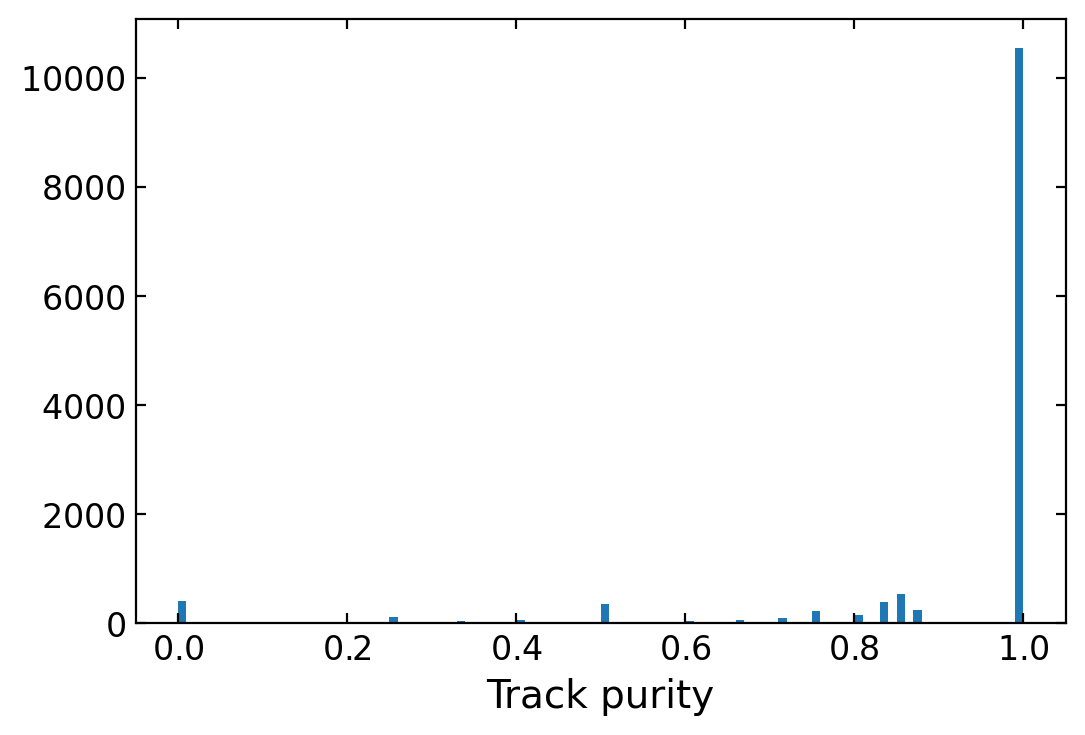

In [15]:
hist(tracks_purity);
xlabel("Track purity")
sum(tracks_purity==1)/len(tracks_purity)

In [16]:
vertex=box_lim
vertex_CMS = np.array([vertex[1], -vertex[2]+85.47*100, vertex[0]])
vertex_DET = np.array([vertex[0]/100-70-49.5, vertex[1]/100, -vertex[2]/100])

In [27]:
mask = mask_vertex_recon&mask_track_recon#(data["tracks_truth_n"]==2)&
Vertices = util.appcut(data["vertices_recon"],mask)
Vertices = np.array([v[0] for v in Vertices])
tracks_purity = util.appcut(data["tracks_purity"], mask)
tracks_purity = np.array([np.mean(v) for v in tracks_purity])

residual = []
for i in tqdm(range(len(Vertices))):
    residual.append([Vertices[i][2]-vertex_CMS[2],
                     Vertices[i][0]-vertex_CMS[0],
                     Vertices[i][1]-vertex_CMS[1],
                    Vertices[i][3], util.quadsum([Vertices[i][0]-vertex_CMS[0],
                     Vertices[i][1]-vertex_CMS[1],
                     Vertices[i][2]-vertex_CMS[2]])])
    
residual=np.array(residual)

100%|██████████| 6690/6690 [00:00<00:00, 60522.56it/s]


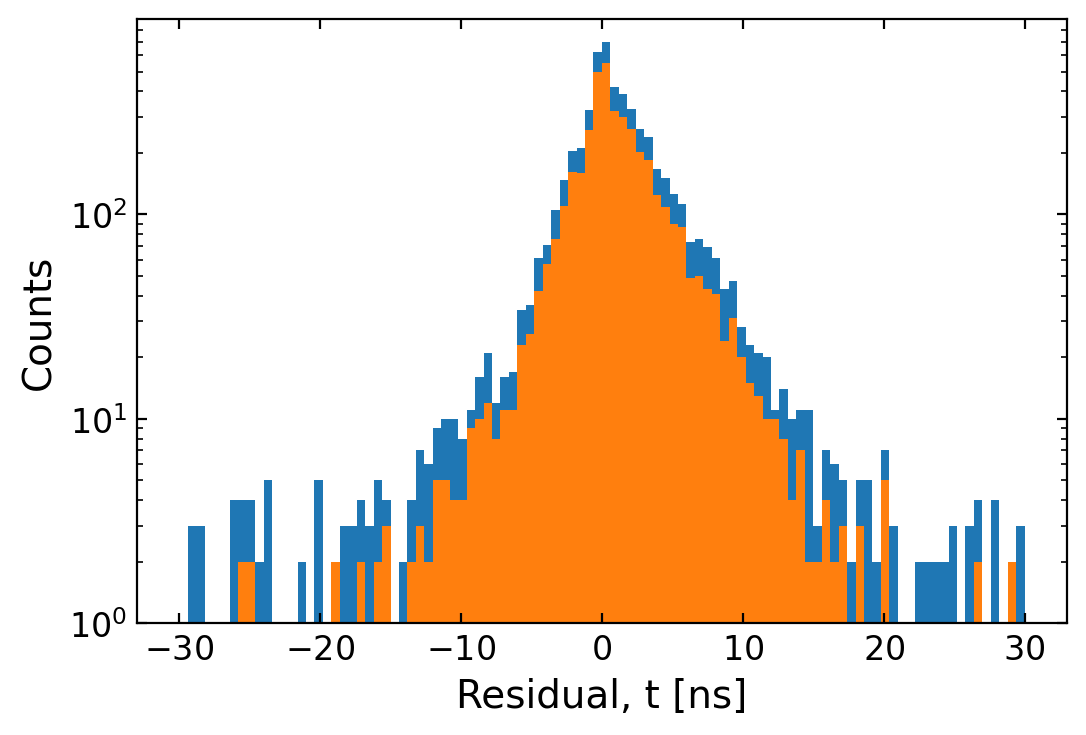

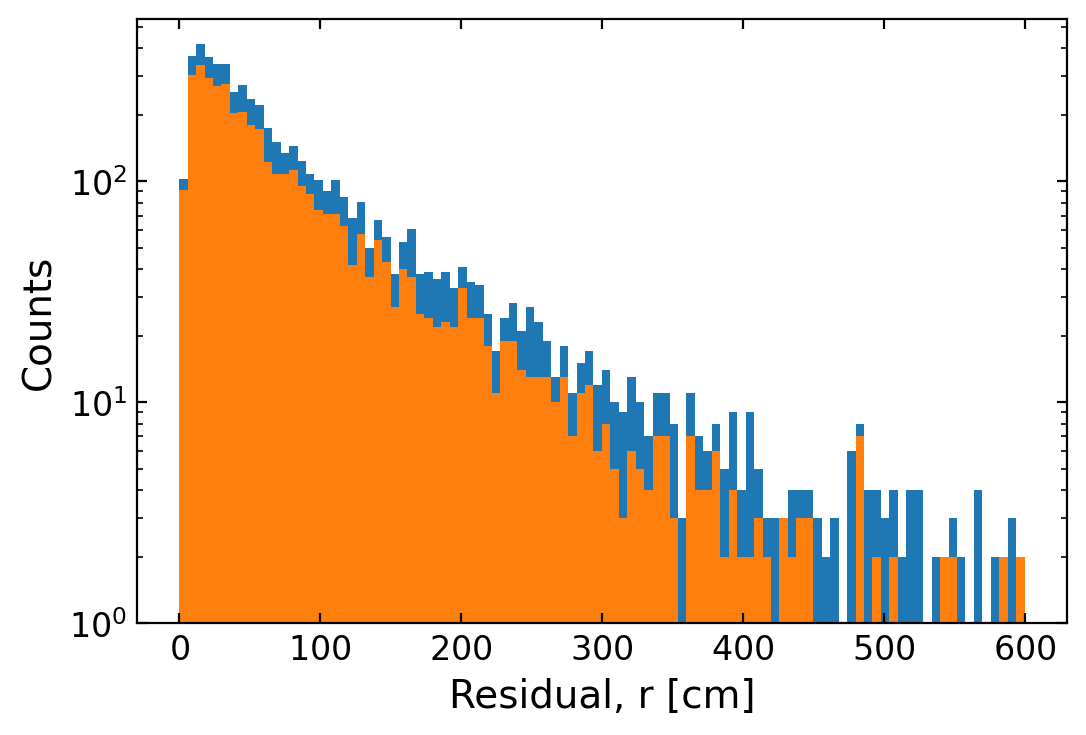

In [28]:
sigmas=[]
labels=["x [cm]", "y [cm]", "z [cm]", "t [ns]", "r [cm]"]
plot_ranges=[[-80,80],[-80,80],[-80,80],[-30,30],[0,600]]

for i in range(5):
    if i<=2:
        continue
    n0,ibins,_ = hist(residual[:,i],range=plot_ranges[i]);
    n,ibins,_ = hist(residual[:,i][tracks_purity>0.99],range=plot_ranges[i]);
    
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    yerr=np.sqrt(n);yerr[yerr==0]=1
    
    
    # fwhm = util.Utils.fwhm(bincenters,n)
    # fwhm = fwhm[1]-fwhm[0]
    
#     # Fit round 1
#     popt,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus")
#     perr = np.sqrt(np.diag(pcov))
#     # Fit round 2
#     mask_fit = (bincenters>(popt[1]-np.abs(popt[2])*3))&(bincenters<(popt[1]+np.abs(popt[2])*3))
#     if i==3:
#         mask_fit = (bincenters>-10)&(bincenters<10)
#     if i==4:
#         mask_fit = (bincenters>0)&(bincenters<40)        
#     popt,pcov = rt.fit_tg(bincenters[mask_fit],n[mask_fit],yerr=yerr[mask_fit],function="gaus")
#     perr = np.sqrt(np.diag(pcov))
#     sigmas.append(popt[2])    
    
    
    # plot(bincenters, util.Utils.Gauss(bincenters,*popt))

    # print("FWHM", fwhm)
    # print("SIGMA", popt[2])
    ylim(1, max(n0)*1.3)  
    xlabel("Residual, "+labels[i])
    ylabel("Counts")
    yscale("log")
    show()

In [34]:
mask_vertex_loose = (np.abs(residual[:,4])<100)
print("Efficiency", sum(mask_vertex_loose)/len(mask))

Efficiency 0.3828


In [23]:
print("Fraction of events track purity >0.9 (with r>100):", sum((np.abs(residual[:,4])>50)&(tracks_purity<0.99))/sum(np.abs(residual[:,4])>50))

Fraction of events track purity >0.9 (with r>100): 0.444659255679072


In [24]:
mask_vertex_loose = (np.abs(residual[:,4])<50)&(tracks_purity>0.99)
print("Efficiency, track purity >0.9:", sum(mask_vertex_loose)/sum(tracks_purity>0.99))

Efficiency, track purity >0.9: 0.47087266866221505


---
Misc

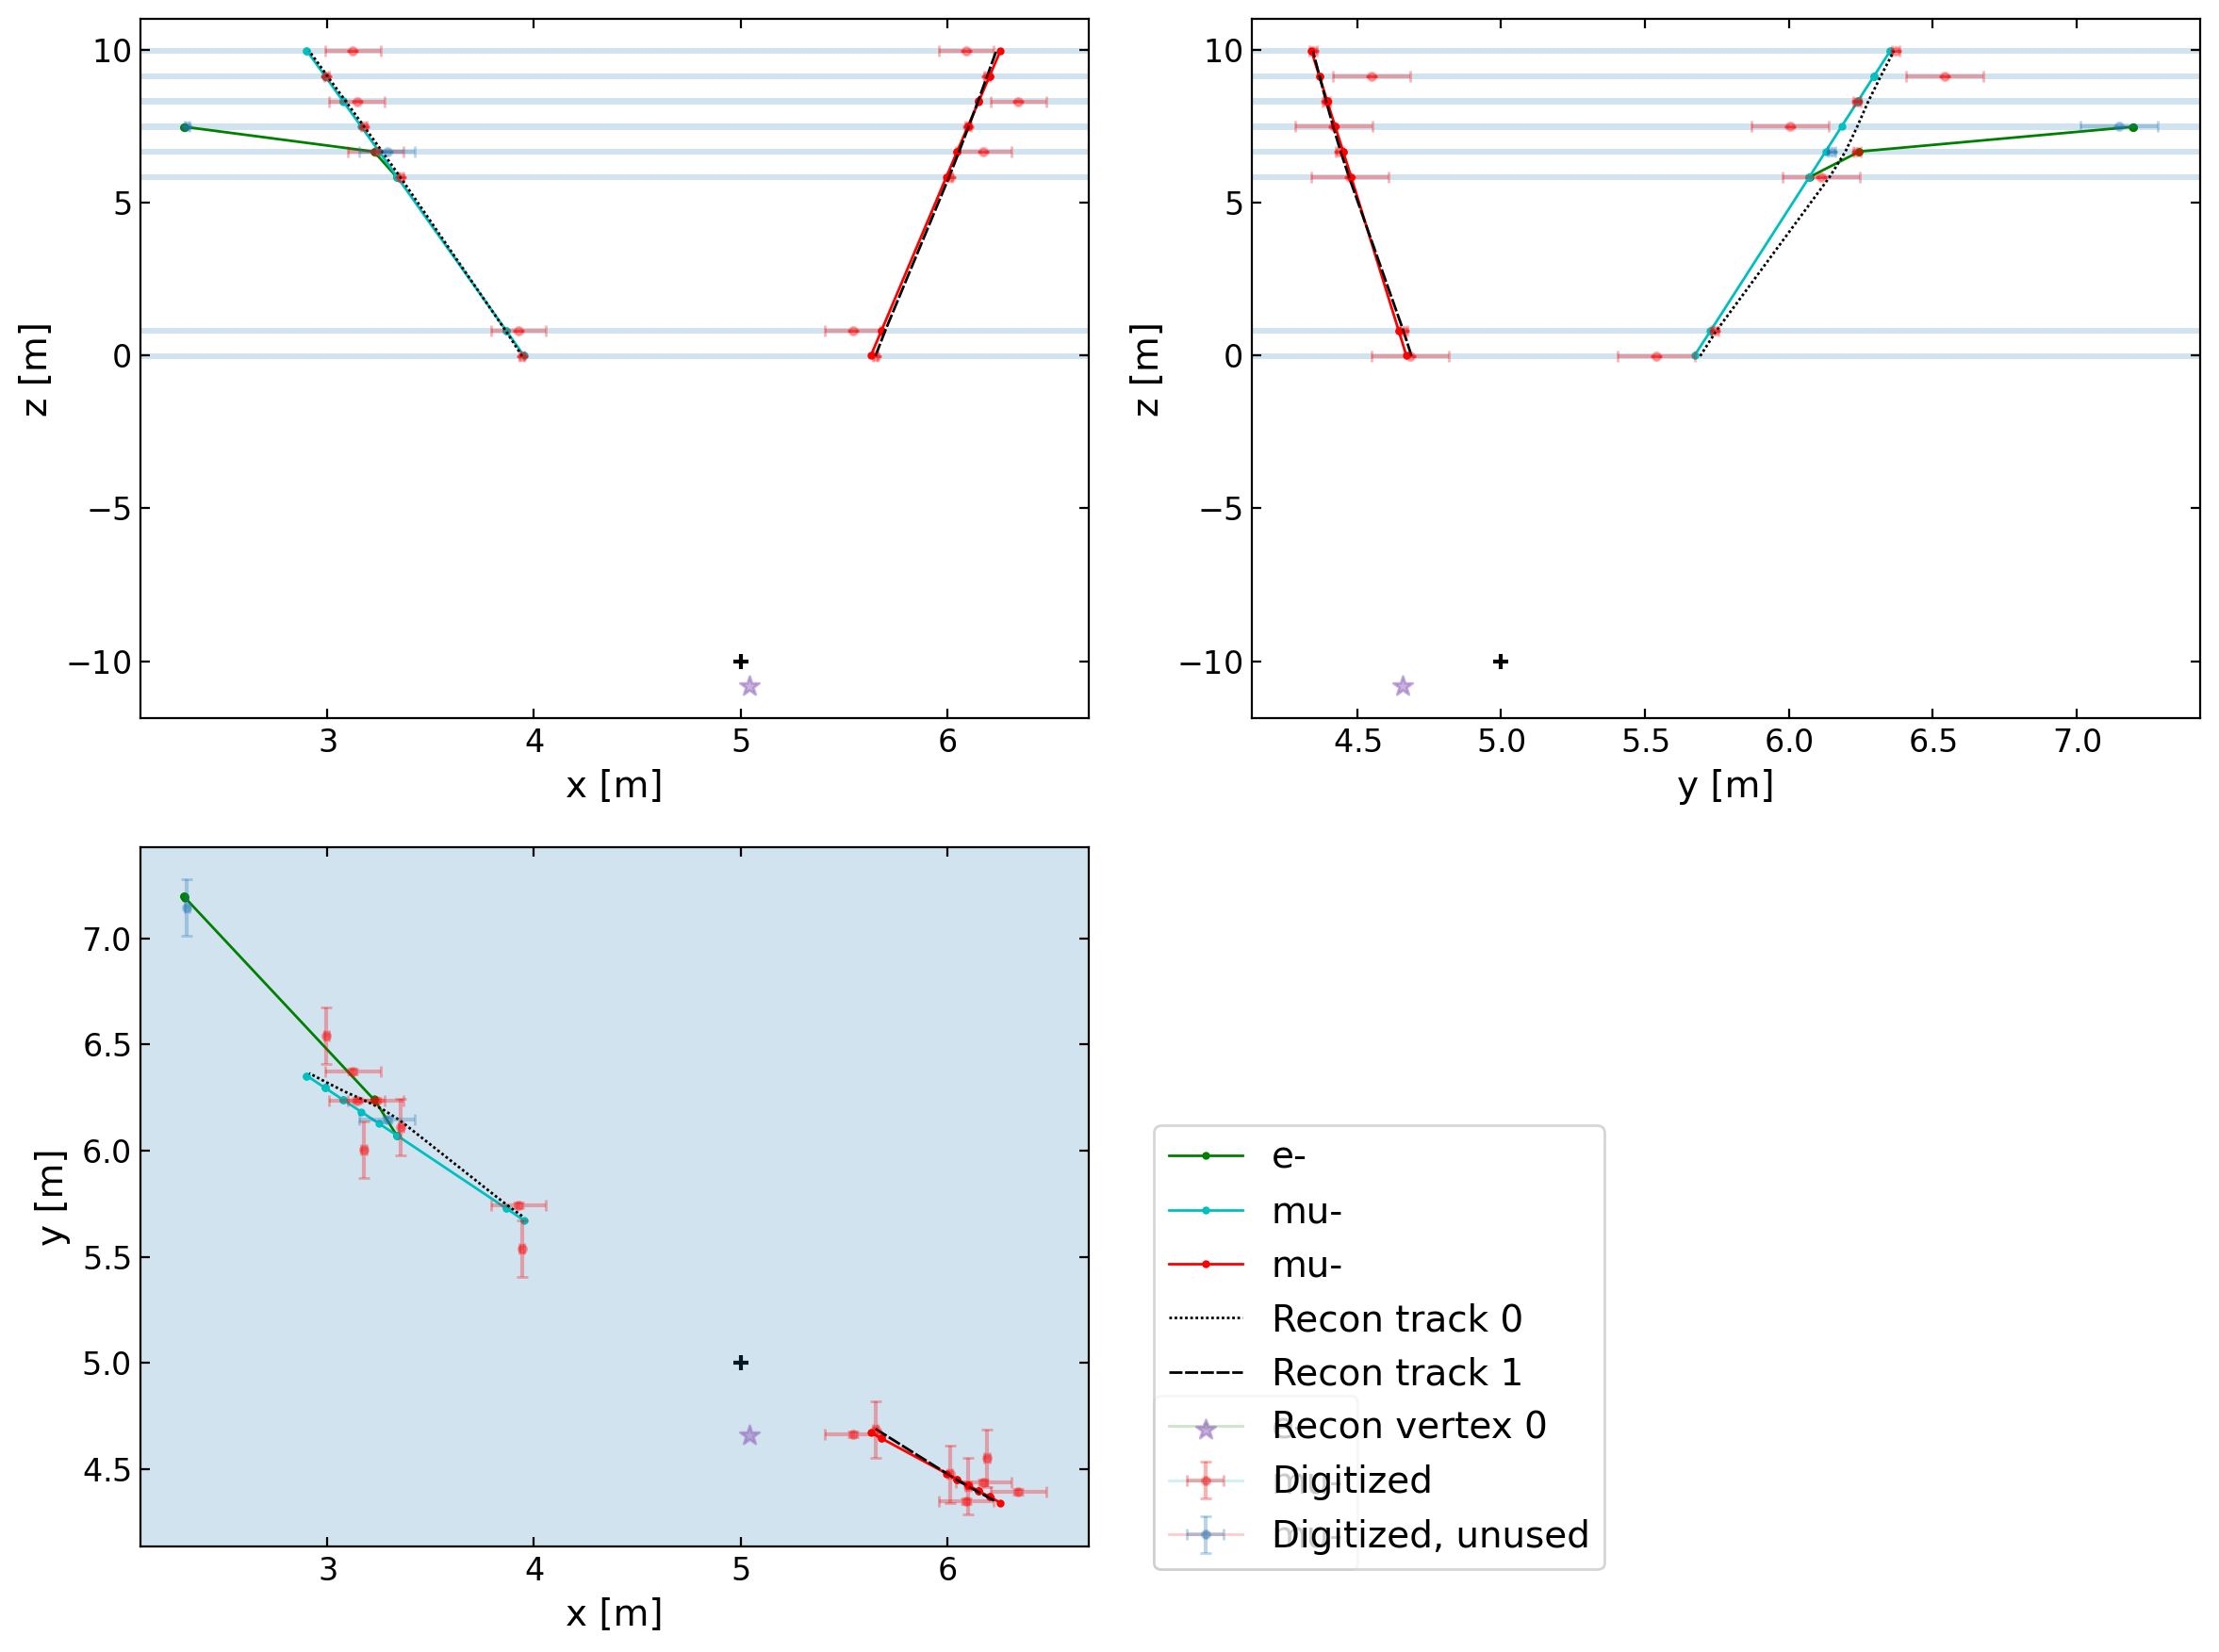

In [21]:
ev.EventNumber+=1
    
# Plot truth
fig,axs=plt.subplots(2,2,figsize=(12,9))
fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=True, disp_first_hit=False);
# Plot the truth vertex
axs=fig.axes
axs[0].scatter(vertex_DET[0],vertex_DET[2],color="black",marker="+")
axs[1].scatter(vertex_DET[1],vertex_DET[2],color="black",marker="+")
axs[2].scatter(vertex_DET[0],vertex_DET[1],color="black",marker="+",label="Vertex Truth ")

# Plot Reconstruction
fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=True);


In [ ]:
Vertices=[]
MaskVertex=[]
for i_event in tqdm(range(nevents)):
    Tree.GetEntry(i_event)

    if len(Tree.Vertex_k_m_y)==0:
        Vertices.append([-9999,-9999,-9999,-9999,-9999,-9999,-9999])
        MaskVertex.append(False)
    else:
        iv = 0
        Vertices.append([Tree.Vertex_k_m_x.at(iv),Tree.Vertex_k_m_y.at(iv),Tree.Vertex_k_m_z.at(iv),Tree.Vertex_k_m_t.at(iv),Tree.Track_k_m_velX.at(iv),Tree.Track_k_m_velY.at(iv),Tree.Track_k_m_velZ.at(iv)])
        MaskVertex.append(True)
        

100%|██████████| 10000/10000 [00:01<00:00, 6105.97it/s]


In [25]:
print(sum(MaskVertex)/len(MaskVertex))

0.9736


In [29]:
residual = []
for i in tqdm(range(nevents)):
    residual.append([Vertices[i][2]-vertex_CMS[2],
                     Vertices[i][0]-vertex_CMS[0],
                     Vertices[i][1]-vertex_CMS[1],
                    Vertices[i][3], util.quadsum([Vertices[i][0]-vertex_CMS[0],
                     Vertices[i][1]-vertex_CMS[1],
                     Vertices[i][2]-vertex_CMS[2]])])
    
residual=np.array(residual)

100%|██████████| 10000/10000 [00:00<00:00, 54557.85it/s]


In [204]:
sigmas=[]
labels=["x", "y", "z", "t", "r"]
plot_ranges=[[-80,80],[-80,80],[-80,80],[-10,10],[0,200]]

for i in range(5):
    n,ibins,_ = hist(residual[:,i][MaskVertex],range=plot_ranges[i]);
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    yerr=np.sqrt(n);yerr[yerr==0]=1
    
    
    fwhm = util.Utils.fwhm(bincenters,n)
    fwhm = fwhm[1]-fwhm[0]
    
    # Fit round 1
    popt,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus")
    perr = np.sqrt(np.diag(pcov))
    # Fit round 2
    mask_fit = (bincenters>(popt[1]-np.abs(popt[2])*3))&(bincenters<(popt[1]+np.abs(popt[2])*3))
    if i==3:
        mask_fit = (bincenters>-10)&(bincenters<10)
    if i==4:
        mask_fit = (bincenters>0)&(bincenters<40)        
    popt,pcov = rt.fit_tg(bincenters[mask_fit],n[mask_fit],yerr=yerr[mask_fit],function="gaus")
    perr = np.sqrt(np.diag(pcov))
    sigmas.append(popt[2])    
    
    
    plot(bincenters, util.Utils.Gauss(bincenters,*popt))

    print("FWHM", fwhm)
    print("SIGMA", popt[2])
    ylim(1, max(n)*1.3)  
    xlabel("Residual "+labels[i])
    # yscale("log")
    show()


NameError: name 'MaskVertex' is not defined

In [39]:
mask_vertex_loose = (np.abs(residual[:,3])<5)&(np.abs(residual[:,4])<50)
print("Efficiency", sum(mask_vertex_loose)/len(mask_vertex_loose))

Efficiency 0.3444
